Universidade Estadual de Campinas - UNICAMP

Faculdade de Engenharia Elétrica e de Computação - FEEC

### IA048 – Aprendizado de Máquina

Alunos:
* Tiago Corrêa de Araújo de Amorim (RA: 100.675)
* Taylon L C Martins (RA: 177.379)

# Lista 02

## Tarefa

Abordar o problema de reconhecimento de atividades humanas (HAR, do inglês _human activity recognition_) a partir de informações capturadas por sensores de smartphones.

Utilizar regressão logística e kNN, com os dados pré-processados e dados brutos.

**Dataset**

* [UCI HAR](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones)

* Human Activity Recognition database built from the recordings of 30 subjects performing activities of daily living (ADL) while carrying a waist-mounted smartphone with embedded inertial sensors.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import multilabel_confusion_matrix

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
# from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score



import numpy as np
# from matplotlib.dates import DateFormatter
# from matplotlib.patches import Patch

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.model_selection import cross_val_score

# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import ElasticNet
# from sklearn.model_selection import GridSearchCV

# from sklearn.metrics import root_mean_squared_error
# from sklearn.metrics import mean_absolute_percentage_error

## Read Preprocessed Dataset

In [3]:
def read_csv_(path, sep=r"\s+|;|:|,"):
    return pd.read_csv(
        filepath_or_buffer=path,
        sep=sep,
        engine='python',
        header=None)

In [4]:
df_labels = read_csv_(r'..\Lista02\UCI_HAR_Dataset\activity_labels.txt')
df_labels.drop(0, axis=1, inplace=True)
df_labels = df_labels.rename(columns={1: 'activity'})

def get_label_name(i):
    return df_labels['activity'][i-1]

In [5]:
df_features = read_csv_(r'..\Lista02\UCI_HAR_Dataset\features.txt', sep=r"\s+")
df_features.drop(0, axis=1, inplace=True)
df_features = df_features.rename(columns={1: 'feature'})

def get_feature_name(i):
    return df_features['feature'][i]

In [6]:
X = read_csv_(r'..\Lista02\UCI_HAR_Dataset\train\X_train.txt')
y = read_csv_(r'..\Lista02\UCI_HAR_Dataset\train\y_train.txt')
X_test = read_csv_(r'..\Lista02\UCI_HAR_Dataset\test\X_test.txt')
y_test = read_csv_(r'..\Lista02\UCI_HAR_Dataset\test\y_test.txt')

In [132]:
print('Train data')
print(f'  X: {X.shape}')
print(f'  y: {y.shape}')
print('Test data')
print(f'  X: {X_test.shape}')
print(f'  y: {y_test.shape}')

Train data
  X: (7352, 561)
  y: (7352, 1)
Test data
  X: (2947, 561)
  y: (2947, 1)


In [133]:
train_labels = y[0].unique()
train_labels.sort()
train_label_count = [len(y[0][y[0]==label]) for label in train_labels]

test_labels = y_test[0].unique()
test_labels.sort()
test_label_count = [len(y_test[0][y_test[0]==label]) for label in test_labels]

print(f'Labels are the same: {np.all(test_labels == train_labels)}')

Labels are the same: True


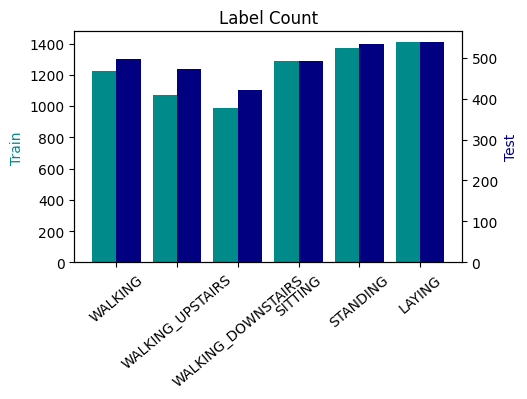

In [134]:
fig, ax1 = plt.subplots(figsize=(5, 3))
labels = [get_label_name(i) for i in train_labels]

ax1.bar(np.arange(len(labels)) - 0.2, train_label_count, color='darkcyan', width=0.4, align='center')
ax1.set_ylabel('Train', color='darkcyan')

ax2 = ax1.twinx()
ax2.bar(np.arange(len(labels)) + 0.2, test_label_count, color='navy', width=0.4, align='center')
ax2.set_ylabel('Test', color='navy')

plt.title('Label Count')
ax1.set_xticks(np.arange(len(labels)))
ax1.set_xticklabels(labels, rotation=40)
plt.savefig('report/png/A_LabelCount.png', bbox_inches='tight')
plt.show()

Dados tem algum desbalanço entre as classes. Será utilizada a acurácia balanceada como métrica da qualidade do classificador (média do _recall_).

In [135]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.250994,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.023692,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,0.134000,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,0.289096,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000


Dados já estão normalizados.

## Logistic Regression

Opções utilizadas:

* Validação cruzada estratificada em 5 pastas.
* Normalização $l_2$ ($\frac{1}{2} ||w||_2^2$), com otimização do seu inverso ($c = \frac{1}{l_2}$)
* Função objetivo da otimização: acurácia balanceada.
* Estratégia: multinomial (entropia cruzada).

Fontes: 

* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html

* https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [136]:
logistic = LogisticRegressionCV(
    cv=5,
    solver='saga',
    scoring='balanced_accuracy',
    random_state=42,
    n_jobs=-1)
logistic.fit(X, y[0].values)

C:\Users\CXZT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\CXZT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\CXZT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\CXZT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: Convergen

LogisticRegressionCV(cv=5, n_jobs=-1, random_state=42,
                     scoring='balanced_accuracy', solver='saga')

In [137]:
print(f'Normalization coefficients l2:\n {[np.round(1/c,4) for c in logistic.C_]}')

Normalization coefficients l2:
 [0.3594, 0.3594, 0.3594, 0.3594, 0.3594, 0.3594]


In [138]:
y_pred = logistic.predict(X_test)

balanced_accuracy = logistic.score(X_test, y_test)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"All Classes - Balanced Accuracy = {balanced_accuracy:0.4f}, F1 score = {f1_macro:0.4f}")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

print("\nPer Class")
accuracy_list = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
for i,c in enumerate(multilabel_confusion_matrix(y_test, y_pred)):
    print(f'{get_label_name(i+1)} - Recall = {accuracy_list[i]:0.4f}, F1 score = {f1[i]:0.4f}')
    print(c)

All Classes - Balanced Accuracy = 0.9598, F1 score = 0.9606
[[493   0   3   0   0   0]
 [ 26 444   1   0   0   0]
 [  3  10 407   0   0   0]
 [  0   3   0 428  60   0]
 [  0   0   0  10 522   0]
 [  0   0   0   0   0 537]]

Per Class
WALKING - Recall = 0.9940, F1 score = 0.9686
[[2422   29]
 [   3  493]]
WALKING_UPSTAIRS - Recall = 0.9427, F1 score = 0.9569
[[2463   13]
 [  27  444]]
WALKING_DOWNSTAIRS - Recall = 0.9690, F1 score = 0.9795
[[2523    4]
 [  13  407]]
SITTING - Recall = 0.8717, F1 score = 0.9214
[[2446   10]
 [  63  428]]
STANDING - Recall = 0.9812, F1 score = 0.9372
[[2355   60]
 [  10  522]]
LAYING - Recall = 1.0000, F1 score = 1.0000
[[2410    0]
 [   0  537]]


In [139]:
def get_classifier_results(model, X_test, y_test, labels, name):
    y_pred = model.predict(X_test)

    balanced_accuracy = recall_score(y_test, y_pred, average='macro')
    f1_macro = f1_score(y_test, y_pred, average='macro')

    print(f"All Classes - Balanced Accuracy = {balanced_accuracy:0.4f}, F1 score = {f1_macro:0.4f}")
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_disp = ConfusionMatrixDisplay(
        confusion_matrix=conf_matrix,
        display_labels=labels)
    conf_matrix_disp.savefig(
        f'report/png/{name}_global_conf_matrix.png',
        bbox_inches='tight')
    conf_matrix_disp.plot()

    print("\nPer Class")
    accuracy_list = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)
    for i,c in enumerate(multilabel_confusion_matrix(y_test, y_pred)):
        print(f'{get_label_name(i+1)} - Recall = {accuracy_list[i]:0.4f}, F1 score = {f1[i]:0.4f}')
        print(c)

Em geral o classificador tem um bom desempenho. Ao analisar por classe, fica claro que o desempenho não é uniforme. A classe 'SITTING' tem um valor de recall bem mais baixo que as demais.

## kNN

Foi feita uma busca em grade para encontrar os melhores parâmetros para o classificador de k-vizinhos mais próximos. A partir desta primeira busca foi feita uma segunda otimização de hiperparâmetros, usando um número maior de pastas na validação cruzada.

In [140]:
param_grid = {
    'n_neighbors': np.arange(3, 6),
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}
knn = KNeighborsClassifier()

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=3,
    scoring='balanced_accuracy',
    n_jobs=-1)
grid_search.fit(X, y[0].values)
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


C:\Users\CXZT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [145]:
for i in range(1,21):
    knn = KNeighborsClassifier(
        n_neighbors=i,
        weights = 'distance',
        p=1,
        n_jobs=-1)
    knn.fit(X, y[0].values)
    print(f'{i}: {knn.score(X_test, y_test):0.4f}')

1: 0.8887
2: 0.8887
3: 0.9050
4: 0.9060
5: 0.9135
6: 0.9135
7: 0.9128
8: 0.9155
9: 0.9169
10: 0.9175
11: 0.9213
12: 0.9199
13: 0.9196
14: 0.9172
15: 0.9179
16: 0.9189
17: 0.9203
18: 0.9230
19: 0.9213
20: 0.9223


In [13]:
X.iloc[2,:]

0      0.279653
1     -0.019467
2     -0.113462
3     -0.995380
4     -0.967187
         ...   
556    0.100699
557    0.808529
558   -0.848933
559    0.180637
560   -0.049118
Name: 2, Length: 561, dtype: float64

In [164]:
def do_kNN_CV(X, y, n_neighbors):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    skf = StratifiedKFold(n_splits=5) #, shuffle=True, random_state=42)
    accuracy = []
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        print(i)
        print(train_index)
        print(test_index)
        X_train, X_test = X.iloc[train_index], X[:][test_index]
    #     y_train, y_test = y[train_index], y[test_index]

    #     knn.fit(X_train, y_train)
    #     y_pred = knn.predict(X_test)
    #     accuracy.append(accuracy_score(y_test, y_pred))
    # return np.mean(accuracy)

In [165]:
do_kNN_CV(X, y[0].values, 5)

0
[1245 1246 1247 ... 7349 7350 7351]
[   0    1    2 ... 1673 1674 1675]


KeyError: "None of [Index([1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254,\n       ...\n       7342, 7343, 7344, 7345, 7346, 7347, 7348, 7349, 7350, 7351],\n      dtype='int32', length=5881)] are in the [columns]"

In [144]:
# y_pred = knn.predict(X_test)
print(knn.score(X_test, y_test))

0.9134713267729895
